## Predicting Wheat Prices - Applied Project Code - George Kapadoukakis

In [1]:
# Import libraries

# Library for making HTTP requests
import requests

# Libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Libraries for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library for interacting with the operating system
import os 

# Libraries for plotting autocorrelation and partial autocorrelation functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

# Libraries for machine learning and model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Library for downloading financial data
import yfinance as yf

# Libraries for building neural network models
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Libraries for time series analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Library used to Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Library for additional math functions
import math  

## Weather Data Preprocessing

In [2]:
# URL of the station metadata file
url = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'

# Define local file path where the downloaded file will be saved
local_file = 'ghcnd-stations.txt'

# Download the file from the URL
response = requests.get(url)
if response.status_code == 200:  # Check if the request was successful
    # Save the content of the response to a local file
    with open(local_file, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded successfully and saved as {local_file}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

# Read the local file into a pandas DataFrame
metadata = pd.read_csv(local_file, sep=r'\s+', header=None, #Sep=\s+: Use whitespace as the delimiter
                       names=['ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE', 'NAME', 'GSN_FLAG', 'HCN/CRN_FLAG', 'WMO_ID'],
                       usecols=['ID', 'LATITUDE', 'LONGITUDE', 'STATE', 'NAME'])

# Filter for Kansas (KS)
KS_metadata = metadata[metadata['STATE'] == 'KS']

# Define the top 10 wheat-producing counties in Kansas
wheat_counties =  ["Sumner",
    "Harper",
    "Reno",
    "McPherson",
    "Kingman",
    "Sedgwick",
    "Pratt",
    "Finney",
    "Barton",
    "Harvey"
]

# Convert county names to uppercase for matching
wheat_counties = [county.upper() for county in wheat_counties]

# Filter metadata to get relevant stations for top wheat-producing counties
selected_stations = KS_metadata[KS_metadata['NAME'].apply(lambda name: any(county in name.split() for county in wheat_counties))]

# Display the relevant stations
print(selected_stations)

File downloaded successfully and saved as ghcnd-stations.txt
                 ID  LATITUDE  LONGITUDE STATE       NAME
70248   US1KSHP0001   37.2772   -98.0298    KS     HARPER
70275   US1KSHV0023   37.9558   -97.4757    KS   SEDGWICK
70384   US1KSKM0010   37.6442   -98.1169    KS    KINGMAN
70386   US1KSKM0014   37.6440   -98.1233    KS    KINGMAN
70387   US1KSKM0015   37.5332   -98.0811    KS    KINGMAN
70388   US1KSKM0018   37.6718   -97.9909    KS    KINGMAN
70389   US1KSKM0019   37.6750   -98.1292    KS    KINGMAN
70390   US1KSKM0020   37.6666   -98.1119    KS    KINGMAN
70516   US1KSMP0001   38.3696   -97.6301    KS  MCPHERSON
70526   US1KSMP0017   38.3652   -97.6618    KS  MCPHERSON
70533   US1KSMP0025   38.2881   -97.7015    KS  MCPHERSON
70535   US1KSMP0028   38.3036   -97.5922    KS  MCPHERSON
70536   US1KSMP0029   38.3475   -97.7883    KS  MCPHERSON
70544   US1KSMP0045   38.3889   -97.6602    KS  MCPHERSON
70545   US1KSMP0046   38.3192   -97.5789    KS  MCPHERSON
70546   US1

In [3]:
# Define a function to download station metadata
def download_metadata(url, local_file):
    # Make a GET request to the specified URL
    response = requests.get(url)
    if response.status_code == 200:  # Check if the request was successful
        # Save the content of the response to a local file
        with open(local_file, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved as {local_file}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

# Download the metadata file
download_metadata(url, local_file)

File downloaded successfully and saved as ghcnd-stations.txt


In [4]:
# Drop rows with NaN values in the 'NAME' column
metadata.dropna(subset=['NAME'], inplace=True)

# List state codes for the specified state
selected_states = ["KS"]
selected_state_stations = metadata[metadata['STATE'].isin(selected_states)]

# Display the unique names of Kansas stations 
unique_station_names = selected_state_stations['NAME'].unique()
print(unique_station_names)

['IOLA' 'HUMBOLDT' 'GARNETT' 'WESTPHALIA' 'COLONY' 'MUSCOTAH' 'ATCHISON'
 'MEDICINE' 'COATS' 'LAKE' 'HAZELTON' 'SHARON' 'BRONSON' 'FORT'
 'UNIONTOWN' 'MAPLETON' 'GARLAND' 'DEVON' 'SAVONBURG' 'HIAWATHA' 'SABETHA'
 'EVEREST' 'HORTON' 'GREAT' 'OLMITZ' 'ELLINWOOD' 'GALATIA' 'HOISINGTON'
 'ROSE' 'EL' 'HAYSVILLE' 'LEON' 'DOUGLASS' 'POTWIN' 'AUGUSTA' 'TOWANDA'
 'ELBING' 'BEAUMONT' 'ROSALIA' 'WHITEWATER' 'BENTON' 'LATHAM' 'ANDOVER'
 'ENGLEWOOD' 'ASHLAND' 'MINNEOLA' 'KINGSDOWN' 'BUCKLIN' 'JAMESTOWN'
 'AURORA' 'CONCORDIA' 'BURLINGTON' 'WAVERLY' 'LE' 'GRIDLEY' 'WEIR'
 'WINFIELD' 'DEXTER' 'ARKANSAS' 'GEUDA' 'CAMBRIDGE' 'COLDWATER' 'WILMORE'
 '19.8' 'PROTECTION' 'SAINT' 'ST.' 'ST' 'BIRD' 'MOLINE' 'PERU' 'PITTSBURG'
 'CHEROKEE' 'MCCUNE' 'GIRARD' 'FARLINGTON' 'FRONTENAC' 'HEPLER' 'CEDAR'
 'COTTONWOOD' 'IDANA' 'WAKEFIELD' 'CLAY' 'MORGANVILLE' 'LONGFORD'
 'NORCATUR' 'TRAER' 'OBERLIN' 'DRESDEN' 'LAWRENCE' 'WELLSVILLE' 'BERRYTON'
 'LECOMPTON' 'OVERBROOK' 'BALDWIN' 'CLINTON' 'EUDORA' 'ENTERPRISE'
 'ABILEN

In [5]:
# Define a function to read .dly files
def read_dly_file(filepath):
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            # Extract station id, year, month and element
            station_id = line[0:11].strip()
            year = int(line[11:15])
            month = int(line[15:17])
            element = line[17:21].strip()
            # Loop through each day of the month
            for day in range(31):
                # Extract the following data for each day
                value_str = line[21 + day * 8:26 + day * 8].strip()
                value = int(value_str) if value_str != '-9999' else None  # Handle missing data
                mflag = line[26 + day * 8:27 + day * 8].strip()  # Measurement flag
                qflag = line[27 + day * 8:28 + day * 8].strip()  # Quality flag
                sflag = line[28 + day * 8:29 + day * 8].strip()  # Source flag
                
                if value is not None:
                    data.append({
                        'station_id': station_id,
                        'year': year,
                        'month': month,
                        'day': day + 1,
                        'element': element,
                        'value': value,
                        'mflag': mflag,
                        'qflag': qflag,
                        'sflag': sflag,
                    })
    return data

# Example usage with a random station
filepath = r"/Users/george/Desktop/Weather Data/ghcnd_all/US1MIKZ0025.dly"
parsed_data = read_dly_file(filepath)

# Convert the parsed data into a DataFrame
df = pd.DataFrame(parsed_data)

# Print the first few rows and shape of the DataFrame
print(df.head())
print('\n', df.shape)

def convert_to_uppercase(series):
    return series.str.upper()

    station_id  year  month  day element  value mflag qflag sflag
0  US1MIKZ0025  2019      7   28    PRCP      0                 N
1  US1MIKZ0025  2019      7   29    PRCP      0                 N
2  US1MIKZ0025  2019      7   30    PRCP     15                 N
3  US1MIKZ0025  2019      7   31    PRCP      0                 N
4  US1MIKZ0025  2019      7   28    SNOW      0                 N

 (1613, 9)


In [6]:
# Define a function to process .dly files
def process_dly_files(data_directory, station_ids):
    weather_data = []
    
    # Iterate through each station ID
    for station_id in station_ids:
        # Construct the file path for the .dly file
        filepath = os.path.join(data_directory, f"{station_id}.dly")
        
        # Check if the file exists
        if os.path.exists(filepath):
            # Parse the .dly file
            parsed_data = read_dly_file(filepath)
            
            # Append station_id to each entry in parsed_data
            for entry in parsed_data:
                entry['station_id'] = station_id
            
            # Extend weather_data with parsed_data
            weather_data.extend(parsed_data)
        
    
    # Convert weather_data into a DataFrame
    df = pd.DataFrame(weather_data)
    
    return df

# Usage for Kansas
if __name__ == '__main__':
    
    # Define the URL for the metadata file
    metadata_url = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
    
    # Define the local file path for the metadata
    local_file = 'ghcnd-stations.txt'
  
    # Define the directory containing the .dly files
    data_directory = r"/Users/george/Desktop/Weather Data/ghcnd_all"
    
    # List of state codes for the selected states
    selected_states = ['KS']
    
    # Download the metadata file
    download_metadata(metadata_url, local_file)
    
    # Read the metadata into a DataFrame
    metadata = pd.read_csv(local_file, sep=r'\s+', header=None,
                           names=['ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE', 'NAME', 'GSN_FLAG', 'HCN/CRN_FLAG', 'WMO_ID'],
                           usecols=['ID', 'STATE', 'NAME'])
    
    # Drop rows with NaN values in the 'NAME' column
    metadata.dropna(subset=['NAME'], inplace=True)
    
    # Convert station names to uppercase
    metadata['NAME'] = convert_to_uppercase(metadata['NAME'])
    
    # Filter stations to include only those in the selected states
    selected_state_stations = metadata[metadata['STATE'].isin(selected_states)]
    
    # Get uppercase station IDs
    station_ids = selected_state_stations['ID']
    
    # Process .dly files for selected station IDs
    weather_data = process_dly_files(data_directory, station_ids)
    
# Print the first few rows and shape of the DataFrame
print(weather_data.head())
print('\n', weather_data.shape)

File downloaded successfully and saved as ghcnd-stations.txt
    station_id  year  month  day element  value mflag qflag sflag
0  US1KSAL0001  2005      8   20    PRCP    157                 N
1  US1KSAL0001  2005      8   21    PRCP     46                 N
2  US1KSAL0001  2005      8   22    PRCP      0                 N
3  US1KSAL0001  2005      8   23    PRCP      0                 N
4  US1KSAL0001  2005      8   24    PRCP     99                 N

 (49631932, 9)


In [7]:
# Filter the weather data to include only the rows where the 'element' column has values 'PRCP', 'TMAX', or 'TMIN'
weather_data_filtered = weather_data[weather_data['element'].isin(['PRCP','TMAX','TMIN'])]

# Print the first few rows and shape of the DataFrame
print(weather_data_filtered.head())
print('\n', weather_data_filtered.shape)

    station_id  year  month  day element  value mflag qflag sflag
0  US1KSAL0001  2005      8   20    PRCP    157                 N
1  US1KSAL0001  2005      8   21    PRCP     46                 N
2  US1KSAL0001  2005      8   22    PRCP      0                 N
3  US1KSAL0001  2005      8   23    PRCP      0                 N
4  US1KSAL0001  2005      8   24    PRCP     99                 N

 (23571380, 9)


In [8]:
# Create a 'date' column by combining 'year', 'month', and 'day' columns
weather_data_filtered['date'] = pd.to_datetime(weather_data_filtered[['year', 'month', 'day']])

# Drop the 'year', 'month', and 'day' columns as they are no longer needed
weather_data_filtered = weather_data_filtered.drop(columns=['year', 'month', 'day'])

# Print the first few rows and shape of the DataFrame
print(weather_data_filtered.head())
print('\n', weather_data_filtered.shape)

    station_id element  value mflag qflag sflag       date
0  US1KSAL0001    PRCP    157                 N 2005-08-20
1  US1KSAL0001    PRCP     46                 N 2005-08-21
2  US1KSAL0001    PRCP      0                 N 2005-08-22
3  US1KSAL0001    PRCP      0                 N 2005-08-23
4  US1KSAL0001    PRCP     99                 N 2005-08-24

 (23571380, 7)


In [9]:
# Pivot the DataFrame for precipitation, maximum temperature, and minimum temperature
# Create separate DataFrames for each element, with 'date' as the index and station IDs as columns
prcp_pivot = weather_data_filtered[weather_data_filtered['element'] == 'PRCP'].pivot(index='date', columns='station_id', values='value').add_suffix('_PRCP')
tmax_pivot = weather_data_filtered[weather_data_filtered['element'] == 'TMAX'].pivot(index='date', columns='station_id', values='value').add_suffix('_TMAX')
tmin_pivot = weather_data_filtered[weather_data_filtered['element'] == 'TMIN'].pivot(index='date', columns='station_id', values='value').add_suffix('_TMIN')

# Merge the pivoted DataFrames
# First join PRCP with TMAX, then join the result with TMIN
combined_df = prcp_pivot.join(tmax_pivot, how='outer').join(tmin_pivot, how='outer')

# Calculate average temperature for each station
for station_id in weather_data_filtered['station_id'].unique():
    tmax_col = f"{station_id}_TMAX"
    tmin_col = f"{station_id}_TMIN"
    # Check if both TMAX and TMIN columns exist for the station
    if tmax_col in combined_df.columns and tmin_col in combined_df.columns:
        # Calculate average temperature and add as a new column
        combined_df[f"{station_id}_AVG_TEMP"] = (combined_df[tmax_col] + combined_df[tmin_col]) / 2

# Print the last few rows and shape of the DataFrame
print(combined_df.tail())
print('\n', combined_df.shape)

station_id  US1KSAL0001_PRCP  US1KSAL0002_PRCP  US1KSAL0004_PRCP  \
date                                                               
2024-07-03               0.0               NaN               NaN   
2024-07-04             191.0               NaN             229.0   
2024-07-05               0.0               NaN               NaN   
2024-07-06               0.0               NaN               NaN   
2024-07-07               0.0               NaN               NaN   

station_id  US1KSAL0005_PRCP  US1KSAL0007_PRCP  US1KSAN0002_PRCP  \
date                                                               
2024-07-03               NaN               NaN               NaN   
2024-07-04               NaN               NaN               NaN   
2024-07-05               NaN               NaN               NaN   
2024-07-06               NaN               NaN               NaN   
2024-07-07               NaN               NaN               NaN   

station_id  US1KSAN0003_PRCP  US1KSAN0005_PRCP

In [10]:
# Identify columns related to precipitation (PRCP)
prcp_columns = [col for col in combined_df.columns if '_PRCP' in col]

# Identify columns to check for NaN values (excluding 'date' and PRCP columns)
columns_to_check = combined_df.columns.difference(['date'] + prcp_columns)

# Drop rows where all columns except 'date' are NaN
combined_df.dropna(how='all', subset=columns_to_check, inplace=True)

# Drop rows where PRCP is 0 and all other columns except 'date' are NaN
condition = (combined_df[columns_to_check].isna().all(axis=1)) & (combined_df[prcp_columns].fillna(0).eq(0).all(axis=1))
combined_df = combined_df[~condition]

# Print the last few rows and shape of the processed DataFrame
print(combined_df.tail())
print('\n', combined_df.shape)

station_id  US1KSAL0001_PRCP  US1KSAL0002_PRCP  US1KSAL0004_PRCP  \
date                                                               
2024-07-03               0.0               NaN               NaN   
2024-07-04             191.0               NaN             229.0   
2024-07-05               0.0               NaN               NaN   
2024-07-06               0.0               NaN               NaN   
2024-07-07               0.0               NaN               NaN   

station_id  US1KSAL0005_PRCP  US1KSAL0007_PRCP  US1KSAN0002_PRCP  \
date                                                               
2024-07-03               NaN               NaN               NaN   
2024-07-04               NaN               NaN               NaN   
2024-07-05               NaN               NaN               NaN   
2024-07-06               NaN               NaN               NaN   
2024-07-07               NaN               NaN               NaN   

station_id  US1KSAN0003_PRCP  US1KSAN0005_PRCP

In [11]:
for station_id in weather_data_filtered['station_id'].unique():
    tmax_col = f"{station_id}_TMAX"
    tmin_col = f"{station_id}_TMIN"
    if tmax_col in combined_df.columns and tmin_col in combined_df.columns:
        # Convert TMAX and TMIN from tenths of degrees Celsius to degrees Celsius
        combined_df[tmax_col] = combined_df[tmax_col] / 10
        combined_df[tmin_col] = combined_df[tmin_col] / 10
        # Recalculate the average temperature
        combined_df[f"{station_id}_AVG_TEMP"] = (combined_df[tmax_col] + combined_df[tmin_col]) / 2

# Drop rows where all columns except for 'date' are NaN and PRCP is 0
prcp_columns = [col for col in combined_df.columns if '_PRCP' in col]
columns_to_check = combined_df.columns.difference(prcp_columns)

# Drop rows where all columns except 'date' are NaN
combined_df.dropna(how='all', subset=columns_to_check, inplace=True)

# Drop rows where PRCP is 0 and all other columns except 'date' are NaN
condition = (combined_df[columns_to_check].isna().all(axis=1)) & (combined_df[prcp_columns].fillna(0).eq(0).all(axis=1))
combined_df = combined_df[~condition]

# Calculate the average temperature across all stations for each date
avg_temperature = combined_df.filter(regex='_AVG_TEMP$', axis=1).mean(axis=1)

# Calculate the average precipitation across all stations for each date
avg_precipitation = combined_df.filter(regex='_PRCP$', axis=1).mean(axis=1) / 10  # Convert from tenths of mm to mm

# Create a new DataFrame with 'date', 'temperature', and 'precipitation' columns
final_df = pd.DataFrame({
    'temperature': avg_temperature,
    'precipitation': avg_precipitation
})

# Rename the columns to have the first letter uppercase
final_df.rename(columns={'temperature': 'Temperature', 'precipitation': 'Precipitation'}, inplace=True)

# Print the first few rows and shape of the final DataFrame
print(final_df.head())
print('\n',final_df.shape)

            Temperature  Precipitation
date                                  
1868-10-01        14.15            0.0
1868-10-02        17.25            0.0
1868-10-03        15.25            0.0
1868-10-04        16.65            0.0
1868-10-05        17.80            0.0

 (51572, 2)


## Loading Predictors and Target Variable

In [12]:
# Download Soybeans Futures Closing prices from Yahoo Finance
ticker_symbol = "ZS=F"
Soybeans_Data = yf.download(ticker_symbol)

# Reset the index to make the date a column
Soybeans_Data = Soybeans_Data.reset_index()

# Select the 'Date' and 'Close' columns
Soybeans_Data = Soybeans_Data[['Date', 'Close']]

# Convert the 'Date' column to datetime with the format 'YYYY-MM-DD'
Soybeans_Data['Date'] = pd.to_datetime(Soybeans_Data['Date'])
Soybeans_Data['Date'] = Soybeans_Data['Date'].dt.strftime('%Y-%m-%d')

# Rename the 'Date' column to 'date' and 'Close' column to 'Soybeans_Price'
Soybeans_Data.rename(columns={"Date": "date", "Close": "Soybeans_Price"}, inplace=True)

# Display the first few rows of the DataFrame 
Soybeans_Data.head()

[*********************100%%**********************]  1 of 1 completed


,date,Soybeans_Price
0,2000-09-15,493.75
1,2000-09-18,484.00
2,2000-09-19,484.25
3,2000-09-20,483.25
4,2000-09-21,486.50


In [13]:
# Load Wheat Production data from the specified file path
excel_file_path = '/Users/george/Desktop/Kansas_Wheat_Production_1966_2023.xlsx'
Production_Data = pd.read_excel(excel_file_path)

# Rename columns for clarity
Production_Data.columns = ['Year', 'Production']

# Convert the 'Year' column to datetime format
Production_Data['Year'] = pd.to_datetime(Production_Data['Year'], format='%Y')

# Set the 'Year' column as the index
Production_Data.set_index('Year', inplace=True)
daily_index = pd.date_range(start=Production_Data.index.min(), end='2023-12-31', freq='D')
Production_Daily_Data = pd.DataFrame(index=daily_index)
Production_Daily_Data = Production_Daily_Data.reindex(daily_index)
Production_Daily_Data['Wheat_Production'] = Production_Data['Production'].resample('D').interpolate(method='quadratic', order=3)
Production_Daily_Data['Wheat_Production'] = Production_Daily_Data['Wheat_Production'] / 365.25
Production_Daily_Data['Wheat_Production'].fillna(method='ffill', inplace=True)

# Reset the index to get the 'date' column back
Production_Daily_Data.reset_index(inplace=True)
Production_Daily_Data.rename(columns={'index': 'date'}, inplace=True)

# Display the first few rows of the DataFrame 
Production_Daily_Data.head()

,date,Wheat_Production
0,1966-01-01,547.761807
1,1966-01-02,547.900921
2,1966-01-03,548.040158
3,1966-01-04,548.179520
4,1966-01-05,548.319005


In [14]:
# Download Wheat Futures Closing Prices from Yahoo Finance
ticker_symbol = "KE=F"
Wheat_Price_Data = yf.download(ticker_symbol)

# Reset the index to make the date a column
Wheat_Price_Data = Wheat_Price_Data.reset_index()

# Select the 'Date' and 'Close' columns
Wheat_Price_Data = Wheat_Price_Data[['Date', 'Close']]

# Convert the 'Date' column to datetime with the format 'YYYY-MM-DD'
Wheat_Price_Data['Date'] = pd.to_datetime(Wheat_Price_Data['Date'])
Wheat_Price_Data['Date'] = Wheat_Price_Data['Date'].dt.strftime('%Y-%m-%d')

# Rename the 'Date' column to 'date' and 'Close' column to 'Wheat_Price'
Wheat_Price_Data.rename(columns={"Date": "date", "Close": "Wheat_Price"}, inplace=True)

# Display the first few rows of the DataFrame 
Wheat_Price_Data.head()

[*********************100%%**********************]  1 of 1 completed


,date,Wheat_Price
0,2000-09-21,293.75
1,2000-09-22,295.50
2,2000-09-25,299.50
3,2000-09-26,302.00
4,2000-09-27,307.75


In [15]:
# Load Currency Data
excel_file_path = r"/Users/george/Desktop/Georgios_Kapadoukakis_7_16_2024_11_33_49_AM12_excel2007.xlsx"

# Load the Excel file into a DataFrame
Currency_Data = pd.read_excel(excel_file_path)

# Convert the 'date' column to datetime with the format 'MM/DD/YYYY'
Currency_Data['date'] = pd.to_datetime(Currency_Data['date'], format='%m/%d/%Y')

# Convert the date format to 'YYYY-MM-DD'
Currency_Data['date'] = Currency_Data['date'].dt.strftime('%Y-%m-%d')

# Display the first few rows of the DataFrame 
Currency_Data.head()

,date,USDJPY
0,1862-07-31,0.7076
1,1862-08-31,0.6690
2,1862-09-30,0.6626
3,1862-10-31,0.6397
4,1862-11-30,0.5922


In [16]:
# Load Inflation Data
excel_file_path = r"/Users/george/Desktop/Georgios_Kapadoukakis_7_8_2024_5_41_22_AM301_excel2007.xlsx"

# Load the Excel file into a DataFrame
TIPS_Data = pd.read_excel(excel_file_path)

# Convert the 'date' column to datetime with the format 'MM/DD/YYYY'
TIPS_Data['date'] = pd.to_datetime(TIPS_Data['date'], format='%m/%d/%Y')

# Convert the date format to 'YYYY-MM-DD'
TIPS_Data['date'] = TIPS_Data['date'].dt.strftime('%Y-%m-%d')

# Adjust the 'USA Inflation Indexed 10-year Bond Yield' column
TIPS_Data["USA Inflation Indexed 10-year Bond Yield"] = TIPS_Data["USA Inflation Indexed 10-year Bond Yield"] / 100
TIPS_Data.rename(columns= {"USA Inflation Indexed 10-year Bond Yield":"USA_Inflation_Indexed_10-year_Bond_Yield"}, inplace=True)

# Load the T-bill CSV file into a DataFrame
csv_file_path = r"/Users/george/Desktop/10 year Tbill.csv"
Tbill_Data = pd.read_csv(csv_file_path)

# Convert the 'date' column in Tbill_Data to datetime format
Tbill_Data['DATE'] = pd.to_datetime(Tbill_Data['DATE'])

# Convert the date format to 'YYYY-MM-DD'
Tbill_Data['DATE'] = Tbill_Data['DATE'].dt.strftime('%Y-%m-%d')

# Rename the 'DATE' column to 'date' for consistency
Tbill_Data.rename(columns={"DATE": "date"}, inplace=True)

# Convert the 'DGS10=Yield' column to numeric, coerce errors to NaN
Tbill_Data['DGS10'] = pd.to_numeric(Tbill_Data['DGS10'], errors='coerce')

# Adjust the 'DGS10=Yield' column by dividing by 100
Tbill_Data["DGS10"] = Tbill_Data["DGS10"] / 100

# Merge the DataFrames on the 'date' column using an outer join
Inflation_Data = pd.merge(TIPS_Data, Tbill_Data, on='date', how='outer')

# Calculate the 'Inflation' column as the difference between the TIPS yield and the T-bill yield
Inflation_Data["Inflation"] = Inflation_Data["USA_Inflation_Indexed_10-year_Bond_Yield"] - Inflation_Data["DGS10"]

# Display the first rows of the merged DataFrame
Inflation_Data.head()

,date,USA_Inflation_Indexed_10-year_Bond_Yield,DGS10,Inflation
0,1962-01-02,NaN,0.0406,NaN
1,1962-01-03,NaN,0.0403,NaN
2,1962-01-04,NaN,0.0399,NaN
3,1962-01-05,NaN,0.0402,NaN
4,1962-01-08,NaN,0.0403,NaN


In [17]:
# Load Natural Gas price related data
excel_file_path = r"/Users/george/Desktop/Natural Gas Price.xlsx"

# Load the Excel file into a DataFrame
Natural_Gas_Data = pd.read_excel(excel_file_path)

# Convert the 'date' column to datetime with the format 'MM/DD/YYYY'
Natural_Gas_Data['date'] = pd.to_datetime(Natural_Gas_Data['date'], format='%m/%d/%Y')

# Convert the date format to 'YYYY-MM-DD'
Natural_Gas_Data['date'] = Natural_Gas_Data['date'].dt.strftime('%Y-%m-%d')

# Display the first few rows DataFrame 
Natural_Gas_Data.head()

,date,Natural_Gas_Price
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


In [18]:
# Download Wheat Futures Volume data from Yahoo Finance
ticker_symbol = "KE=F"
volume_data = yf.download(ticker_symbol)

# Reset the index to make the date a column
volume_data = volume_data.reset_index()

# Select the 'Date' and 'Volume' columns
Wheat_Futures_Volume = volume_data[['Date', 'Volume']]

# Convert the 'Date' column to datetime with the format 'YYYY-MM-DD'
Wheat_Futures_Volume['Date'] = pd.to_datetime(Wheat_Futures_Volume['Date'])
Wheat_Futures_Volume['Date'] = Wheat_Futures_Volume['Date'].dt.strftime('%Y-%m-%d')

# Rename the 'Date' column to 'date' and 'Volume' column to 'Wheat_Futures_Volume'
Wheat_Futures_Volume.rename(columns={"Date": "date", "Volume": "Wheat_Futures_Volume"}, inplace=True)

# Display the first few rows of the DataFrame 
Wheat_Futures_Volume.head()

[*********************100%%**********************]  1 of 1 completed


,date,Wheat_Futures_Volume
0,2000-09-21,4842
1,2000-09-22,3945
2,2000-09-25,5073
3,2000-09-26,9180
4,2000-09-27,11145


In [19]:
# List the dataframes to be processed
dataframes = [Soybeans_Data, Production_Daily_Data, Wheat_Price_Data, Inflation_Data, Currency_Data, Natural_Gas_Data, Wheat_Futures_Volume]

# Set the 'date' column as the index for each dataframe
for df in dataframes:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  
    df.set_index('date', inplace=True)  # We set date column as index

# Find the earliest and latest dates across all dataframes
earliest_date = min(df.index.min() for df in dataframes)
latest_date = max(df.index.max() for df in dataframes)

# Create a date range from the earliest to the latest date
date_range = pd.date_range(start=earliest_date, end=latest_date)

# Reindex each dataframe to include all dates in the range, filling missing dates with NaN
reindexed_dataframes = [df.reindex(date_range) for df in dataframes]

# Combine all dataframes into one, aligning on the date index
combined_df = pd.concat(reindexed_dataframes, axis=1)

# Reset index to make the date a column again
combined_df.reset_index(inplace=True)
combined_df.rename(columns={'index': 'date'}, inplace=True)

# If 'date' is part of the index, reset the index to make it a column
if 'date' not in final_df.columns:
    final_df.reset_index(inplace=True)  

# Verify the columns 
print("Columns in final_df after resetting index:", final_df.columns)

Columns in final_df after resetting index: Index(['date', 'Temperature', 'Precipitation'], dtype='object')


In [20]:
# Check the date range in both dataframes before filtering
print("Earliest date in final_df:", final_df['date'].min())
print("Latest date in final_df:", final_df['date'].max())
print("Earliest date in combined_df:", combined_df['date'].min())
print("Latest date in combined_df:", combined_df['date'].max())

# Define the date range for filtering
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2023-12-31')

# Filter both DataFrames to the specified date range
final_df_filtered = final_df[(final_df['date'] >= start_date) & (final_df['date'] <= end_date)]
combined_df_filtered = combined_df[(combined_df['date'] >= start_date) & (combined_df['date'] <= end_date)]

# Check if filtered DataFrames have valid date ranges
print("Earliest date in final_df_filtered:", final_df_filtered['date'].min())
print("Latest date in final_df_filtered:", final_df_filtered['date'].max())
print("Earliest date in combined_df_filtered:", combined_df_filtered['date'].min())
print("Latest date in combined_df_filtered:", combined_df_filtered['date'].max())

# Merge the filtered DataFrames on 'date'
df = pd.merge(final_df_filtered, combined_df_filtered, on='date', how='outer')

# Display the shape and first few rows of the updated DataFrame to verify the merge
print('\n',df.shape)
df.head(10)

Earliest date in final_df: 1868-10-01 00:00:00
Latest date in final_df: 2024-07-07 00:00:00
Earliest date in combined_df: 1862-07-31 00:00:00
Latest date in combined_df: 2024-08-08 00:00:00
Earliest date in final_df_filtered: 2000-01-01 00:00:00
Latest date in final_df_filtered: 2023-12-31 00:00:00
Earliest date in combined_df_filtered: 2000-01-01 00:00:00
Latest date in combined_df_filtered: 2023-12-31 00:00:00

 (8766, 12)


,date,Temperature,Precipitation,Soybeans_Price,Wheat_Production,Wheat_Price,USA_Inflation_Indexed_10-year_Bond_Yield,DGS10,Inflation,USDJPY,Natural_Gas_Price,Wheat_Futures_Volume
0,2000-01-01,7.216443,0.005190,NaN,952.224504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,6.377365,0.099313,NaN,951.881527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,0.687500,1.341237,NaN,951.541019,NaN,0.0435,0.0658,-0.0223,101.56,NaN,NaN
3,2000-01-04,-5.910714,2.365052,NaN,951.202981,NaN,0.0433,0.0649,-0.0216,103.25,2.16,NaN
4,2000-01-05,-2.833766,0.097270,NaN,950.867412,NaN,0.0436,0.0662,-0.0226,104.27,2.17,NaN
5,2000-01-06,1.093506,0.005119,NaN,950.534313,NaN,0.0438,0.0657,-0.0219,105.31,2.18,NaN
6,2000-01-07,0.476948,0.058562,NaN,950.203683,NaN,0.0438,0.0652,-0.0214,105.35,2.19,NaN
7,2000-01-08,2.308681,0.270242,NaN,949.875523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2000-01-09,3.028571,0.153265,NaN,949.549832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2000-01-10,3.694333,0.018900,NaN,949.226610,NaN,0.0440,0.0657,-0.0217,105.10,2.20,NaN


In [21]:
# Calculate returns
df['Log_Return_Wheat_Price'] = np.log(df['Wheat_Price'] / df['Wheat_Price'].shift(1))
df['Log_Return_Soybeans_Price'] = np.log(df['Soybeans_Price'] / df['Soybeans_Price'].shift(1))
df['Log_Return_Natural_Gas_Price'] = np.log(df['Natural_Gas_Price'] / df['Natural_Gas_Price'].shift(1))
df['Wheat_Production_Change'] = df['Wheat_Production'] / df['Wheat_Production'].shift(1)
df["USDJPY_Return"] = np.log(df['USDJPY'] / df['USDJPY'].shift(1))
df["Wheat_Futures_Volume_Change"]= df['Wheat_Futures_Volume'] / df['Wheat_Futures_Volume'].shift(1)
df["Inflation_Change"]= df["Inflation"] - df["Inflation"].shift(1)

# Display the shape and last few rows of the updated DataFrame to verify the changes
df = df.dropna()
print('\n',df.shape)
df.tail()


 (3673, 19)


,date,Temperature,Precipitation,Soybeans_Price,Wheat_Production,Wheat_Price,USA_Inflation_Indexed_10-year_Bond_Yield,DGS10,Inflation,USDJPY,Natural_Gas_Price,Wheat_Futures_Volume,Log_Return_Wheat_Price,Log_Return_Soybeans_Price,Log_Return_Natural_Gas_Price,Wheat_Production_Change,USDJPY_Return,Wheat_Futures_Volume_Change,Inflation_Change
8755,2023-12-21,7.980769,0.170788,1297.25,550.992471,626.75,0.017009,0.0389,-0.021891,142.10,2.48,19574.0,0.002796,-0.008444,0.000000,1.0,-0.010013,1.105501,-0.000035
8756,2023-12-22,8.561905,5.716113,1299.75,550.992471,623.00,0.017082,0.0390,-0.021918,142.45,2.54,16496.0,-0.006001,0.001925,0.023906,1.0,0.002460,0.842751,-0.000027
8761,2023-12-27,-0.509722,1.036406,1316.75,550.992471,635.00,0.016362,0.0379,-0.021538,141.83,2.63,18207.0,-0.012131,0.002662,0.050693,1.0,-0.004643,0.964507,0.000242
8762,2023-12-28,-0.413732,0.277080,1305.25,550.992471,643.75,0.016787,0.0384,-0.021613,141.45,2.55,19169.0,0.013685,-0.008772,-0.030890,1.0,-0.002683,1.052837,-0.000075
8763,2023-12-29,0.736111,0.060128,1293.50,550.992471,642.00,0.017163,0.0388,-0.021637,141.06,2.58,19012.0,-0.002722,-0.009043,0.011696,1.0,-0.002761,0.991810,-0.000024


In [22]:
# Check for infinite values
inf_counts = np.isinf(df).sum()
print("Infinite values in each column:\n", inf_counts)

# Filter out rows with infinite values in the Wheat_Futures_Volume_Change variable
df = df[np.isfinite(df['Wheat_Futures_Volume_Change'])]

# Check for infinite values again
inf_counts = np.isinf(df).sum()
print("Infinite values in each column:\n", inf_counts)

Infinite values in each column:
 date                                         0
Temperature                                  0
Precipitation                                0
Soybeans_Price                               0
Wheat_Production                             0
Wheat_Price                                  0
USA_Inflation_Indexed_10-year_Bond_Yield     0
DGS10                                        0
Inflation                                    0
USDJPY                                       0
Natural_Gas_Price                            0
Wheat_Futures_Volume                         0
Log_Return_Wheat_Price                       0
Log_Return_Soybeans_Price                    0
Log_Return_Natural_Gas_Price                 0
Wheat_Production_Change                      0
USDJPY_Return                                0
Wheat_Futures_Volume_Change                 32
Inflation_Change                             0
dtype: int64
Infinite values in each column:
 date                        

In [23]:
# Create the desired order of columns of the Dataframe
desired_order = [
    'date', 
    'Wheat_Price', 
    'Log_Return_Wheat_Price',
    'Temperature', 
    'Precipitation', 
    'Soybeans_Price', 
    'Log_Return_Soybeans_Price',
    'Wheat_Production', 
    'Wheat_Production_Change',
    'USA_Inflation_Indexed_10-year_Bond_Yield',
    'DGS10', 
    'Inflation',
    'Inflation_Change',
    'USDJPY', 
    'USDJPY_Return',
    'Natural_Gas_Price', 
    'Log_Return_Natural_Gas_Price', 
    'Wheat_Futures_Volume',
    'Wheat_Futures_Volume_Change'
    
]

# Reindex the DataFrame
df = df[desired_order]

# Display the first few rows of the reordered DataFrame and its shape
print('\n',df.shape)
df.head()


 (3641, 19)


,date,Wheat_Price,Log_Return_Wheat_Price,Temperature,Precipitation,Soybeans_Price,Log_Return_Soybeans_Price,Wheat_Production,Wheat_Production_Change,USA_Inflation_Indexed_10-year_Bond_Yield,DGS10,Inflation,Inflation_Change,USDJPY,USDJPY_Return,Natural_Gas_Price,Log_Return_Natural_Gas_Price,Wheat_Futures_Volume,Wheat_Futures_Volume_Change
265,2000-09-22,295.50,0.005940,19.125497,2.740878,491.0,0.009207,928.917619,0.999842,0.0399,0.0585,-0.0186,0.0003,107.90,0.012684,5.16,0.000000,3945.0,0.814746
269,2000-09-26,302.00,0.008313,11.778105,0.003020,496.5,0.000000,928.299412,0.999828,0.0399,0.0581,-0.0182,0.0003,107.55,-0.001765,5.28,0.030772,9180.0,1.809580
270,2000-09-27,307.75,0.018861,15.526623,0.001007,492.5,-0.008089,928.137056,0.999825,0.0397,0.0583,-0.0186,-0.0004,107.31,-0.002234,5.34,0.011300,11145.0,1.214052
271,2000-09-28,310.75,0.009701,17.490584,0.000000,497.0,0.009096,927.971577,0.999822,0.0397,0.0582,-0.0185,0.0001,107.57,0.002420,5.20,-0.026567,12214.0,1.095917
272,2000-09-29,320.00,0.029332,19.314803,0.045819,499.0,0.004016,927.802976,0.999818,0.0396,0.0580,-0.0184,0.0001,108.05,0.004452,5.10,-0.019418,8930.0,0.731128


In [24]:
# Function to determine the appropriate transformation
def determine_transformation(column):
    if pd.api.types.is_numeric_dtype(column):
        skewness = column.skew()
        range_span = column.max() - column.min()
        print(f"Evaluating {column.name}: Skewness={skewness}, Range={range_span}")
        
        if 'Log_Return' in column.name or 'Return' in column.name:
            return 'No Scaling'
        elif np.abs(skewness) > 1:
            return 'Log Scaling'
        elif np.abs(skewness) < 0.5 and range_span > 1:
            return 'StandardScaler'
        else:
            return 'MinMaxScaler'
    else:
        return 'Non-numeric'

# Apply the transformation determination function to each column
transformations = df.apply(determine_transformation)

# Filter out non-numeric columns from transformations
transformations = transformations[transformations != 'Non-numeric']

# Print out the recommended transformations
print("Recommended Transformations:")
print(transformations)

# Define columns based on recommendations
minmax_columns = transformations[transformations == 'MinMaxScaler'].index.tolist()
standard_columns = transformations[transformations == 'StandardScaler'].index.tolist()
log_columns = transformations[transformations == 'Log Scaling'].index.tolist()
no_scaling_columns = transformations[transformations == 'No Scaling'].index.tolist()

# Initialize the scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply Standard Scaling
df[standard_columns] = standard_scaler.fit_transform(df[standard_columns])

# Apply Min-Max Scaling
df[minmax_columns] = minmax_scaler.fit_transform(df[minmax_columns])

# Apply Log Transformation
df[log_columns] = df[log_columns].apply(lambda x: np.log1p(x))

# Check for NA and Inf Values
combined_counts = (df.isna() | np.isinf(df)).sum()
print("NaN and infinite values in each column:\n", combined_counts)
df = df.dropna()
combined_counts = (df.isna() | np.isinf(df)).sum()
print("NaN and infinite values in each column:\n", combined_counts)

# Display first few rows and shape of the DataFrame
print('\n',df.shape)
df.head()

Evaluating Wheat_Price: Skewness=0.941210649393007, Range=1052.25
Evaluating Log_Return_Wheat_Price: Skewness=0.12939217630019365, Range=0.1534908973100565
Evaluating Temperature: Skewness=-0.31127541156737576, Range=50.528120070113935
Evaluating Precipitation: Skewness=3.3307352460101947, Range=54.60601659751037
Evaluating Soybeans_Price: Skewness=0.31145981408431705, Range=1351.75
Evaluating Log_Return_Soybeans_Price: Skewness=-0.7714376988145187, Range=0.21472167110994306
Evaluating Wheat_Production: Skewness=0.3794834177567422, Range=770.7761957932614
Evaluating Wheat_Production_Change: Skewness=0.3494021256774832, Range=0.004556121793416579
Evaluating USA_Inflation_Indexed_10-year_Bond_Yield: Skewness=0.20279800279981658, Range=0.05180586
Evaluating DGS10: Skewness=0.05417865196835565, Range=0.0538
Evaluating Inflation: Skewness=0.35843144833014945, Range=0.025147359999999997
Evaluating Inflation_Change: Skewness=-0.09246724358254736, Range=0.004283099999999997
Evaluating USDJPY: 

,date,Wheat_Price,Log_Return_Wheat_Price,Temperature,Precipitation,Soybeans_Price,Log_Return_Soybeans_Price,Wheat_Production,Wheat_Production_Change,USA_Inflation_Indexed_10-year_Bond_Yield,DGS10,Inflation,Inflation_Change,USDJPY,USDJPY_Return,Natural_Gas_Price,Log_Return_Natural_Gas_Price,Wheat_Futures_Volume,Wheat_Futures_Volume_Change
265,2000-09-22,0.022096,0.005940,0.547852,1.319320,-1.360663,0.009207,0.320734,0.414733,1.000000,0.990706,0.459435,0.649786,-0.440240,0.012684,1.818077,0.000000,8.280458,0.595945
269,2000-09-26,0.028273,0.008313,-0.146734,0.003016,-1.345054,0.000000,0.317336,0.411758,1.000000,0.983271,0.475341,0.649786,-0.468085,-0.001765,1.837370,0.030772,9.124891,1.033035
270,2000-09-27,0.033737,0.018861,0.207632,0.001006,-1.356406,-0.008089,0.316443,0.411013,0.996139,0.986989,0.459435,0.486353,-0.487179,-0.002234,1.846879,0.011300,9.318836,0.794824
271,2000-09-28,0.036588,0.009701,0.393295,0.000000,-1.343635,0.009096,0.315533,0.410268,0.996139,0.985130,0.463412,0.603091,-0.466494,0.002420,1.824549,-0.026567,9.410420,0.739991
272,2000-09-29,0.045379,0.029332,0.565748,0.044801,-1.337959,0.004016,0.314607,0.409523,0.994209,0.981413,0.467388,0.603091,-0.428306,0.004452,1.808289,-0.019418,9.097284,0.548773


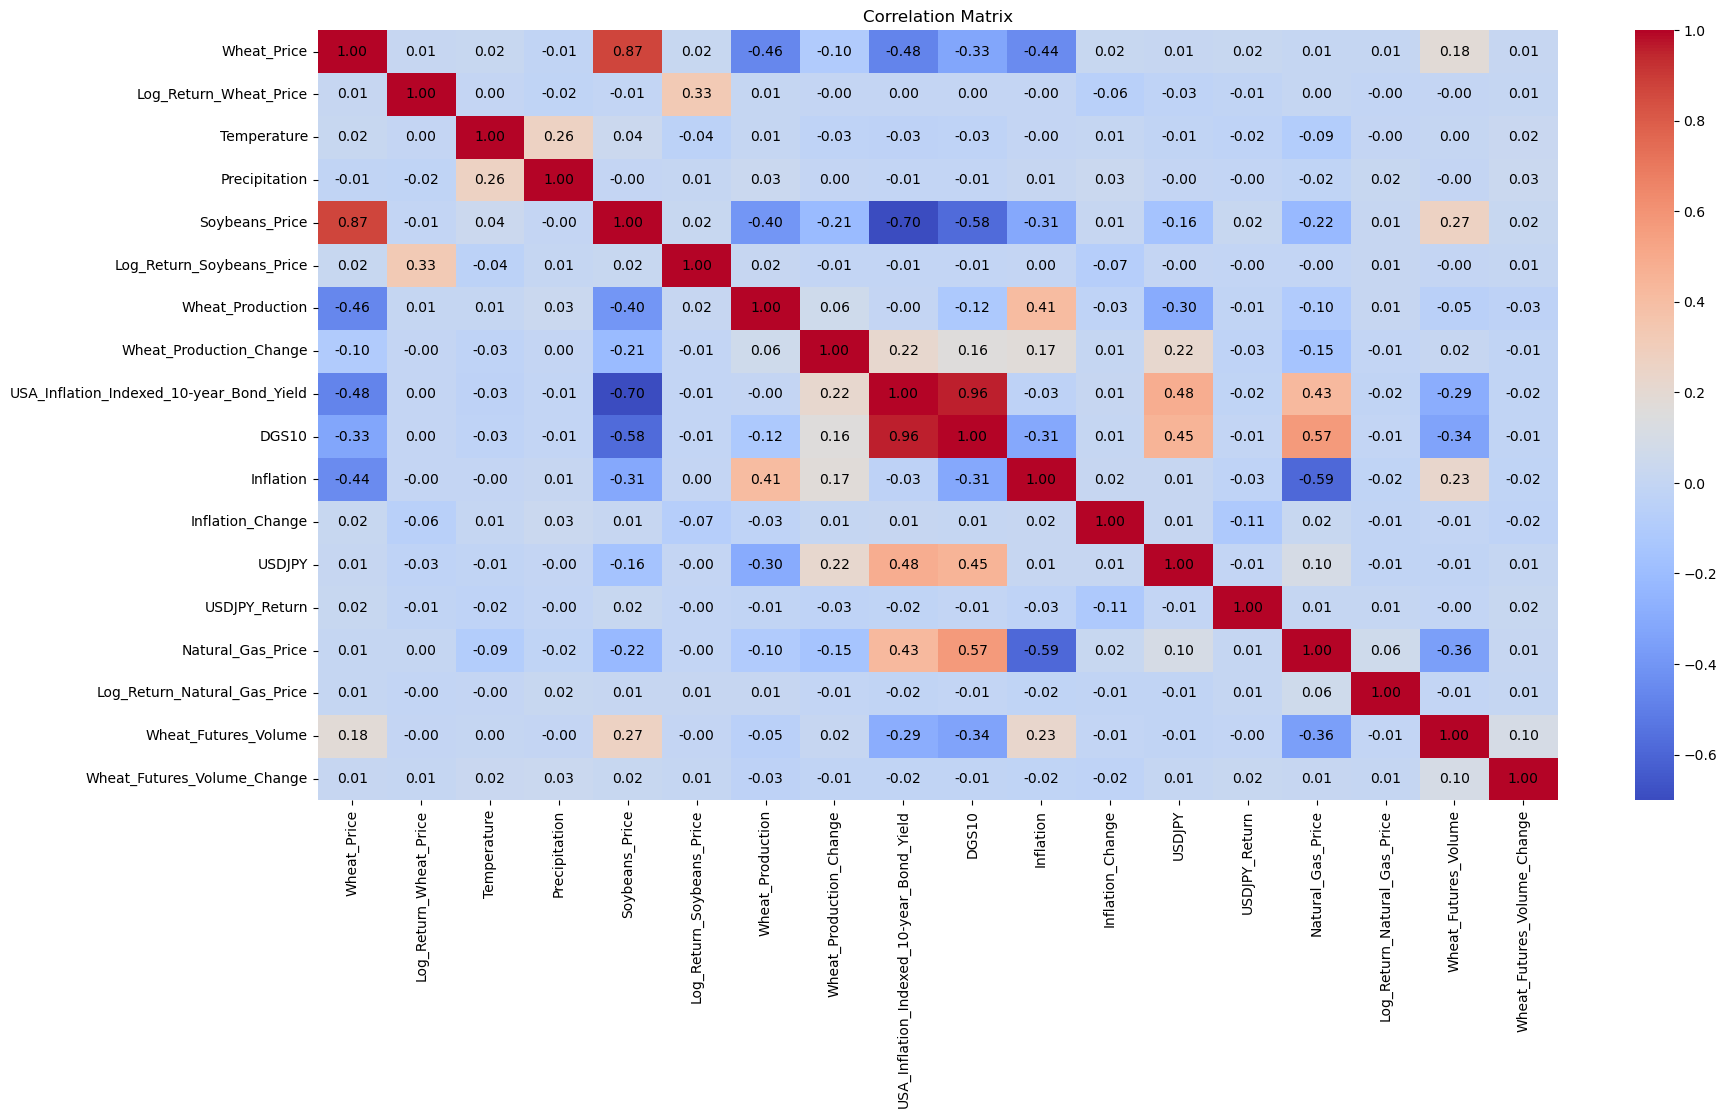

,Wheat_Price,Log_Return_Wheat_Price,Temperature,Precipitation,Soybeans_Price,Log_Return_Soybeans_Price,Wheat_Production,Wheat_Production_Change,USA_Inflation_Indexed_10-year_Bond_Yield,DGS10,Inflation,Inflation_Change,USDJPY,USDJPY_Return,Natural_Gas_Price,Log_Return_Natural_Gas_Price,Wheat_Futures_Volume,Wheat_Futures_Volume_Change
Wheat_Price,1.000000,0.010052,0.019797,-0.012799,0.871330,0.022182,-0.463532,-0.100540,-0.476075,-0.326954,-0.442622,0.020692,0.011842,0.022350,0.005820,0.005038,0.177993,0.010992
Log_Return_Wheat_Price,0.010052,1.000000,0.002996,-0.021487,-0.009637,0.325384,0.006363,-0.001810,0.002851,0.002899,-0.000670,-0.057941,-0.027180,-0.012941,0.003752,-0.004405,-0.002848,0.006274
Temperature,0.019797,0.002996,1.000000,0.262596,0.041237,-0.036621,0.009452,-0.028442,-0.031274,-0.029347,-0.001303,0.008129,-0.014042,-0.024113,-0.086512,-0.000442,0.004567,0.024676
Precipitation,-0.012799,-0.021487,0.262596,1.000000,-0.002820,0.005248,0.032761,0.003284,-0.005438,-0.008359,0.011268,0.034232,-0.000527,-0.003551,-0.019421,0.020128,-0.002889,0.032840
Soybeans_Price,0.871330,-0.009637,0.041237,-0.002820,1.000000,0.022243,-0.397852,-0.213107,-0.700979,-0.577527,-0.312466,0.010903,-0.158304,0.020585,-0.221331,0.012406,0.266439,0.017629
Log_Return_Soybeans_Price,0.022182,0.325384,-0.036621,0.005248,0.022243,1.000000,0.015850,-0.009639,-0.005401,-0.005718,0.002069,-0.070992,-0.002202,-0.003642,-0.004388,0.012956,-0.002507,0.007013
Wheat_Production,-0.463532,0.006363,0.009452,0.032761,-0.397852,0.015850,1.000000,0.057217,-0.002908,-0.118549,0.408682,-0.027635,-0.300600,-0.014697,-0.100040,0.014083,-0.050736,-0.030139
Wheat_Production_Change,-0.100540,-0.001810,-0.028442,0.003284,-0.213107,-0.009639,0.057217,1.000000,0.219960,0.160256,0.172050,0.008971,0.220466,-0.028888,-0.150118,-0.005889,0.016199,-0.010527
USA_Inflation_Indexed_10-year_Bond_Yield,-0.476075,0.002851,-0.031274,-0.005438,-0.700979,-0.005401,-0.002908,0.219960,1.000000,0.959068,-0.031383,0.014623,0.481744,-0.018352,0.425494,-0.015912,-0.285099,-0.016346
DGS10,-0.326954,0.002899,-0.029347,-0.008359,-0.577527,-0.005718,-0.118549,0.160256,0.959068,1.000000,-0.313134,0.009356,0.454734,-0.009234,0.571453,-0.009460,-0.335791,-0.010148


In [25]:
#Check Correlation Matrix
features = ['Wheat_Price', 'Log_Return_Wheat_Price',
       'Temperature', 'Precipitation', 'Soybeans_Price',
       'Log_Return_Soybeans_Price', 'Wheat_Production',
       'Wheat_Production_Change', 'USA_Inflation_Indexed_10-year_Bond_Yield',
       'DGS10', 'Inflation', 'Inflation_Change', 'USDJPY', 'USDJPY_Return',
       'Natural_Gas_Price', 'Log_Return_Natural_Gas_Price',
       'Wheat_Futures_Volume', 'Wheat_Futures_Volume_Change']

corr_matrix = df[features].corr()

# Plot heatmap
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)

# Annotate heatmap with the correlation values
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        text = heatmap.axes.text(j + 0.5, i + 0.5, 
                                 f'{corr_matrix.iloc[i, j]:.2f}', 
                                 ha='center', va='center', color='black')

#Display the Correlation Matrix
plt.title('Correlation Matrix')
plt.savefig('corr_plot.png', dpi=300, bbox_inches='tight')
plt.show()
corr_matrix

In [26]:
# Define the proposed feature combination
features = [  
    'Wheat_Production', 
    'Wheat_Futures_Volume_Change', 
    'Inflation_Change',
    'Temperature', 
    'Precipitation', 
    "Log_Return_Natural_Gas_Price",
    "Log_Return_Soybeans_Price",
    "USDJPY_Return"
    
]
target = 'Log_Return_Wheat_Price'

def calculate_vif(features, df):
    X = df[features]
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

# Calculate VIF for the proposed feature set
vif_original = calculate_vif(features, df)
print("VIF for original predictors:")
print(vif_original)

VIF for original predictors:
                        Feature       VIF
0              Wheat_Production  1.002711
1   Wheat_Futures_Volume_Change  1.740732
2              Inflation_Change  2.350652
3                   Temperature  1.076150
4                 Precipitation  1.740012
5  Log_Return_Natural_Gas_Price  1.003639
6     Log_Return_Soybeans_Price  1.002591
7                 USDJPY_Return  1.002152


In [27]:
# Perform ADF test on
columns = [
    'Wheat_Price', 'Log_Return_Wheat_Price',
       'Temperature', 'Precipitation', 'Soybeans_Price',
       'Log_Return_Soybeans_Price', 'Wheat_Production',
       'Wheat_Production_Change', 'USA_Inflation_Indexed_10-year_Bond_Yield',
        'DGS10', 'Inflation',
       'Inflation_Change', 'USDJPY',
       'USDJPY_Return', 'Natural_Gas_Price', 'Log_Return_Natural_Gas_Price',
       'Wheat_Futures_Volume', 'Wheat_Futures_Volume_Change'
]

# Function to perform ADF test and print the result
def adf_test(series, column_name):
    result = adfuller(series.dropna())
    is_stationary = result[1] < 0.05
    print(f'ADF Statistic for {column_name}: {result[0]}')
    print(f'p-value for {column_name}: {result[1]}')
    print(f'Critical Values for {column_name}:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    print('-----------------------------')
    return is_stationary

# Apply ADF test on each column and classify them as stationary and non-stationary
stationary_columns = []
non_stationary_columns = []

for column in columns:
    if adf_test(df[column], column):
        stationary_columns.append(column)
    else:
        non_stationary_columns.append(column)

#Print the results
print('Stationary columns:')
print(stationary_columns)

print('Non-stationary columns:')
print(non_stationary_columns)

ADF Statistic for Wheat_Price: -2.1277127626778944
p-value for Wheat_Price: 0.23351813285403145
Critical Values for Wheat_Price:
   1%: -3.4321602211641724
   5%: -2.8623398545767365
   10%: -2.56719577511483
-----------------------------
ADF Statistic for Log_Return_Wheat_Price: -59.87520794578554
p-value for Log_Return_Wheat_Price: 0.0
Critical Values for Log_Return_Wheat_Price:
   1%: -3.4321477795421935
   5%: -2.8623343588485692
   10%: -2.5671928493690377
-----------------------------
ADF Statistic for Temperature: -8.421887585229321
p-value for Temperature: 1.9733944736196195e-13
Critical Values for Temperature:
   1%: -3.4321627301819047
   5%: -2.862340962860277
   10%: -2.567196365129181
-----------------------------
ADF Statistic for Precipitation: -9.345477893957018
p-value for Precipitation: 8.56959541809729e-16
Critical Values for Precipitation:
   1%: -3.432155722391455
   5%: -2.8623378673761084
   10%: -2.567194717193812
-----------------------------
ADF Statistic for 

## LSTM

In [28]:
# Define features and target to use in models
features = [  
   'Wheat_Production', 
    'Wheat_Futures_Volume_Change', 
    'Inflation_Change',
    'Temperature', 
    'Precipitation', 
    "Log_Return_Natural_Gas_Price",
    "Log_Return_Soybeans_Price",
    "USDJPY_Return"
]
target = 'Log_Return_Wheat_Price'

# Create input and target arrays
X = df[features].values
y = df[target].values

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, shuffle=False)

# Ensure the date index is preserved for the test set
dates_train = df["date"].iloc[:len(train_labels)]
dates_test = df["date"].iloc[len(train_labels):]

In [29]:
# Function to create sequences for time series data
def create_sequences(data, labels, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = labels[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys).reshape(-1, 1)

# Define sequence length
seq_length = 30 

# Create sequences for training and testing data
train_data_seq, train_labels_seq = create_sequences(train_data, train_labels, seq_length)
test_data_seq, test_labels_seq = create_sequences(test_data, test_labels, seq_length)

# Define model hyperparameters
d_1 = 50  # Output dimension of the first LSTM layer
d_2 = 50  # Output dimension of the second LSTM layer
K = 1     # Output dimension of the last layer 
l2_lambda = 0.001  # L2 regularization factor
dropout_rate = 0.1 # Dropout rate

# Define input tensor
input_tensor = Input(shape=(train_data_seq.shape[1], train_data_seq.shape[2]))  

# Add Bidirectional LSTM layers with Dropout and L2 regularization
lstm_1 = Bidirectional(LSTM(d_1, return_sequences=True, kernel_regularizer=l2(l2_lambda)), name="BiLSTM_1_layer")(input_tensor)
dropout_1 = Dropout(dropout_rate, name="Dropout_1")(lstm_1)

lstm_2 = Bidirectional(LSTM(d_2, return_sequences=False, kernel_regularizer=l2(l2_lambda)), name="BiLSTM_2_layer")(dropout_1)
dropout_2 = Dropout(dropout_rate, name="Dropout_2")(lstm_2)

# Output layer with L2 regularization
output = Dense(K, kernel_regularizer=l2(l2_lambda), name="Output_layer")(dropout_2)

# Define the model
model = Model(inputs=input_tensor, outputs=output)
print(model.summary())

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mse"])

# Define callbacks
checkpoint_filepath = 'model_checkpoint.keras'
callbacks_list = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),  
    ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)  
]

# Train the model
history = model.fit(train_data_seq,
                    train_labels_seq,
                    epochs=30,
                    batch_size=32,
                    callbacks=callbacks_list,
                    validation_split=0.3)

# Evaluate the model
test_loss, test_mse = model.evaluate(test_data_seq, test_labels_seq)
print(f' Loss: {test_loss},  MSE: {test_mse}')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_1_layer (Bidirectional)  │ (None, 30, 100)        │        23,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM_2_layer (Bidirectional)  │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,101 (328.52 KB)

 Trainable params: 84,101 (328.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2527 - mse: 0.0072 - val_loss: 0.1218 - val_mse: 6.4925e-04 - learning_rate: 0.0010
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0997 - mse: 0.0011 - val_loss: 0.0517 - val_mse: 4.9280e-04 - learning_rate: 0.0010
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0438 - mse: 6.0920e-04 - val_loss: 0.0264 - val_mse: 3.0801e-04 - learning_rate: 0.0010
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0234 - mse: 3.7573e-04 - val_loss: 0.0161 - val_mse: 3.1590e-04 - learning_rate: 0.0010
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0146 - mse: 3.1439e-04 - val_loss: 0.0108 - val_mse: 2.6829e-04 - learning_rate: 0.0010
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0099 - mse: 3.0547e-04 - val_loss: 0.0076 - val_mse: 2.6877e-04 - learning_rate: 0.0010
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0070 - mse: 2.4845e-04 - val_loss: 0.0056 - val_

In [30]:
# Calculate LSTM Metrics
test_predictions = model.predict(test_data_seq)
lstm_mse = mean_squared_error(test_labels_seq, test_predictions)
lstm_mae = mean_absolute_error(test_labels_seq, test_predictions)
lstm_rmse = np.sqrt(lstm_mse)
r2 = r2_score(test_labels_seq, test_predictions)

print(f'Test MSE: {lstm_mse:.5f}')
print(f'Test MAE: {lstm_mae:.5f}')
print(f'Test RMSE: {lstm_rmse:.5f}')
print(f'R2: {r2:.5f}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test MSE: 0.00039
Test MAE: 0.01513
Test RMSE: 0.01973
R2: -0.00002


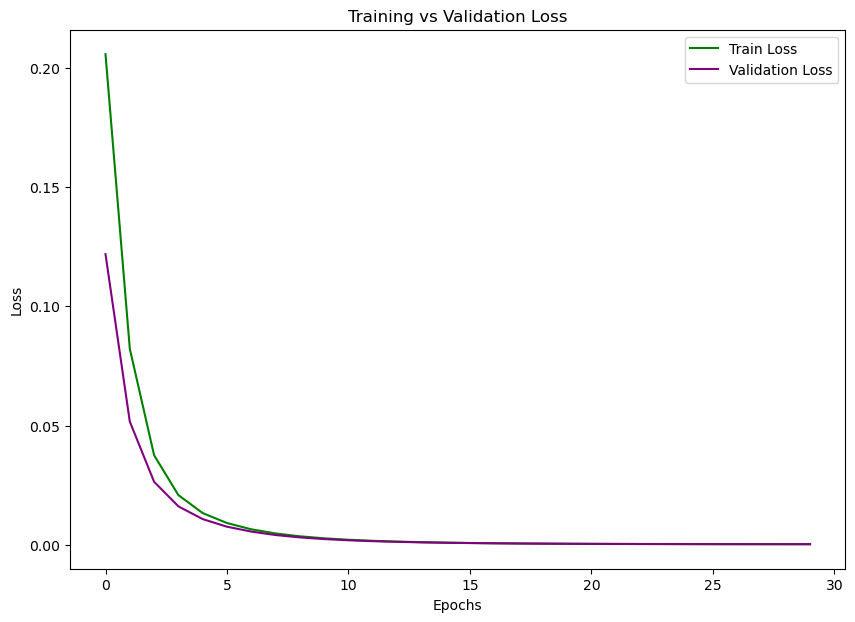

In [31]:
# Plotting Train and Validation Loss
plt.figure(figsize=(10, 7))
plt.plot(history.history["loss"], label="Train Loss" , color='green')
plt.plot(history.history["val_loss"], label="Validation Loss", color="purple")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.savefig('lstm_loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()

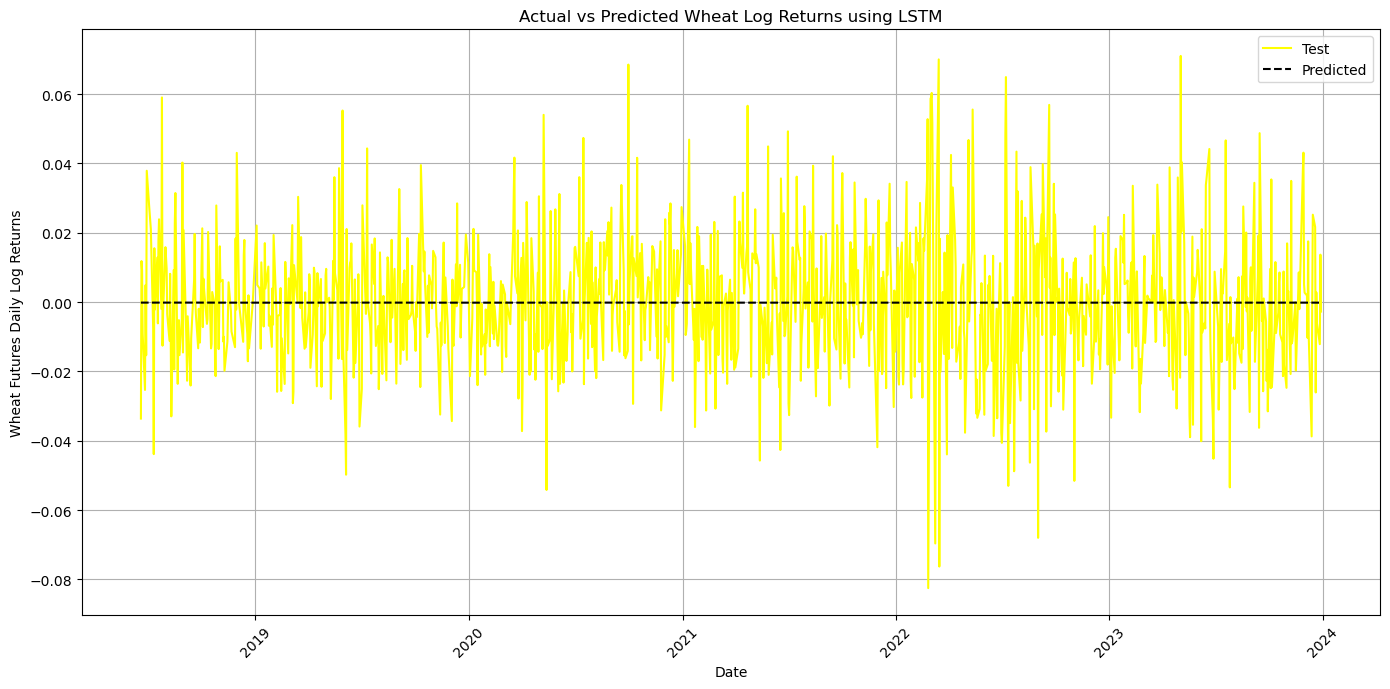

In [32]:
# Define indices using the preserved dates
test_index = dates_test.iloc[-len(test_labels_seq):].values
train_index = dates_train.iloc[-len(train_labels_seq):].values

# Plotting actual vs predicted log returns 
plt.figure(figsize=(14, 7))
plt.plot(test_index, test_labels_seq, label='Test', color='yellow')
plt.plot(test_index, test_predictions, label='Predicted', color='black', linestyle='--')
plt.title('Actual vs Predicted Wheat Log Returns using LSTM')
plt.xlabel('Date')
plt.ylabel('Wheat Futures Daily Log Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('lstm_predictionsvsreality_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## ARIMA

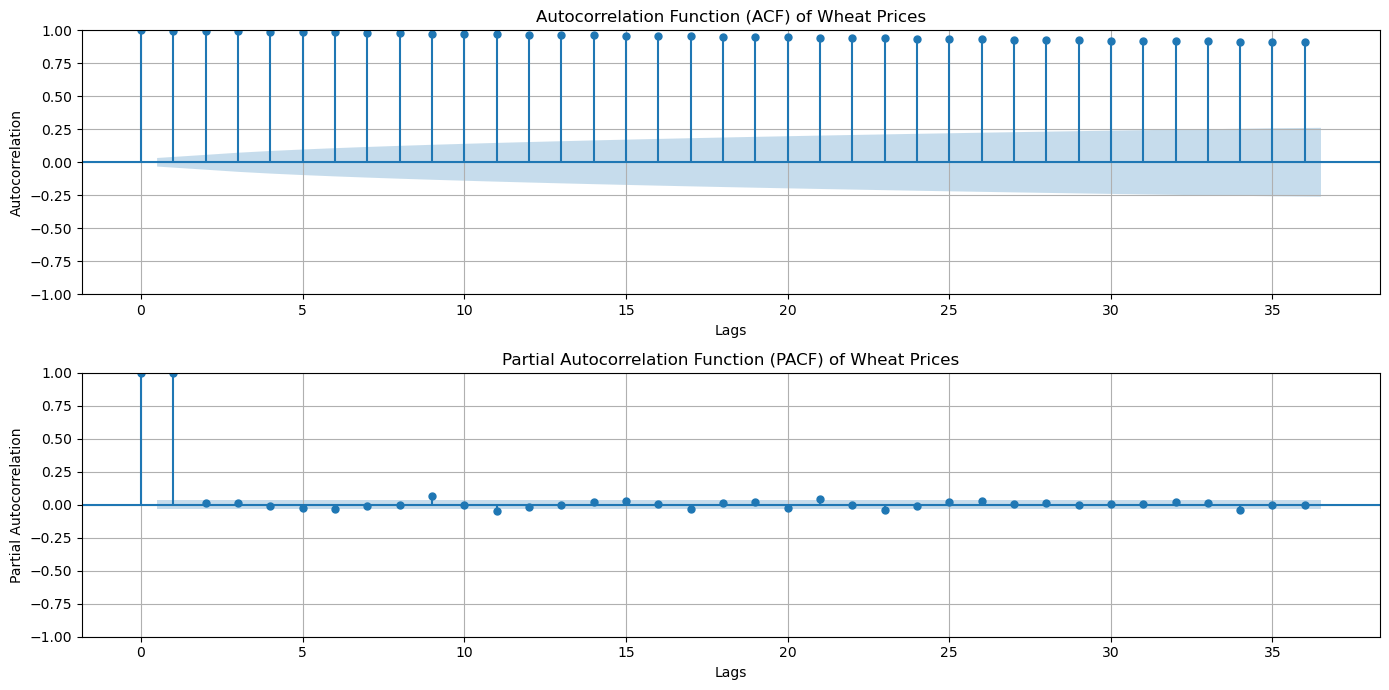

In [33]:
# Create the plots
fig, axes = plt.subplots(2, 1, figsize=(14, 7))

# Plot ACF
plot_acf(df['Wheat_Price'], ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF) of Wheat Prices')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True)

# Plot PACF
plot_pacf(df['Wheat_Price'], ax=axes[1], alpha=0.05)
axes[1].set_title('Partial Autocorrelation Function (PACF) of Wheat Prices')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].grid(True)

# Show the plot
plt.tight_layout()
plt.savefig('ACF_PACF_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Best ARIMA order: (0, 0, 1)


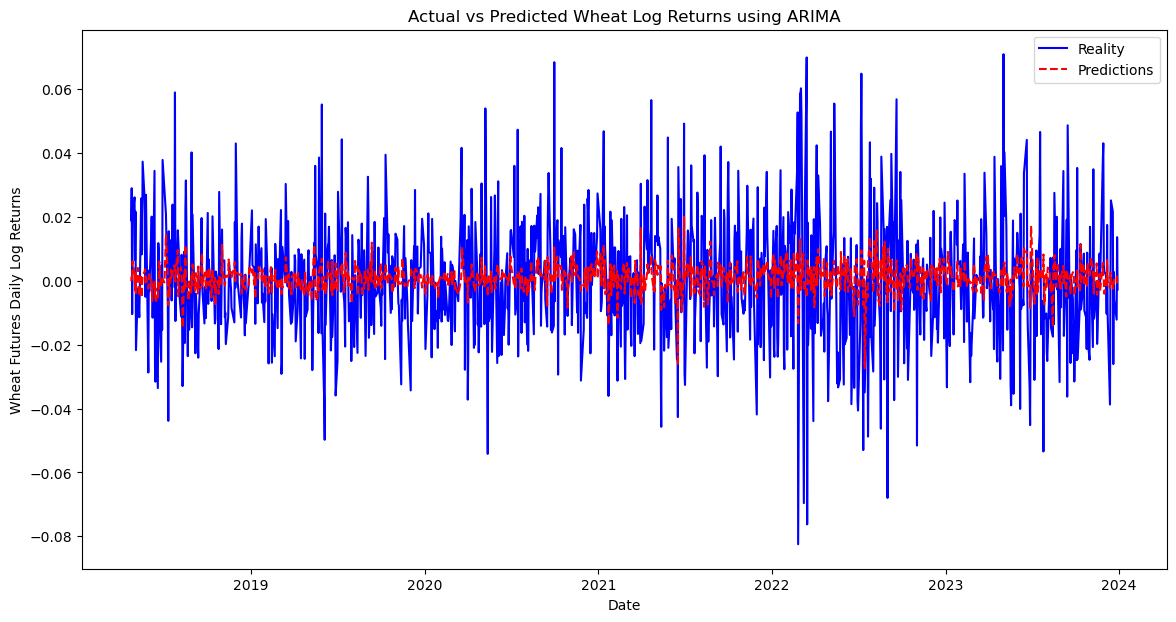

ARIMA - Mean Squared Error: 0.00034
ARIMA - Root Mean Squared Error: 0.01848
ARIMA - Mean Absolute Error: 0.01418
ARIMA - R2: 0.12396


In [34]:
# Identify the best p, d, q order based on the Akaike Information Criterion
def find_best_arima_model(train_labels, train_data):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    pq_range = range(0, 3)  
    d_range = range(0, 1)
    
    for p in pq_range:
        for d in d_range:
            for q in pq_range:
                try:
                    model = ARIMA(train_labels, order=(p, d, q), exog=train_data)
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except:
                    continue
    
    return best_order, best_model

best_order, best_model = find_best_arima_model(train_labels, train_data)
print("Best ARIMA order:", best_order)

# Fit the ARIMA model with the identified best parameters
model = ARIMA(train_labels, order=best_order, exog=train_data)
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(start=len(train_labels), end=len(train_labels) + len(test_labels) - 1, exog=test_data)

# Plot actual vs predicted log returns with dates on x-axis
plt.figure(figsize=(14, 7))
plt.plot(dates_test, test_labels, label='Reality', color='blue')
plt.plot(dates_test, predictions, label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Wheat Futures Daily Log Returns')
plt.title('Actual vs Predicted Wheat Log Returns using ARIMA')
plt.legend()
plt.savefig('arima_predictionsvsreality_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate metrics
mse_arima = mean_squared_error(test_labels, predictions)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(test_labels, predictions)
r2_arima = r2_score(test_labels, predictions)

print(f'ARIMA - Mean Squared Error: {mse_arima:.5f}')
print(f'ARIMA - Root Mean Squared Error: {rmse_arima:.5f}')
print(f'ARIMA - Mean Absolute Error: {mae_arima:.5f}')
print(f'ARIMA - R2: {r2_arima:.5f}')

## Support Vector Regression

Best SVR model: SVR(C=2, epsilon=0.01, kernel='linear')


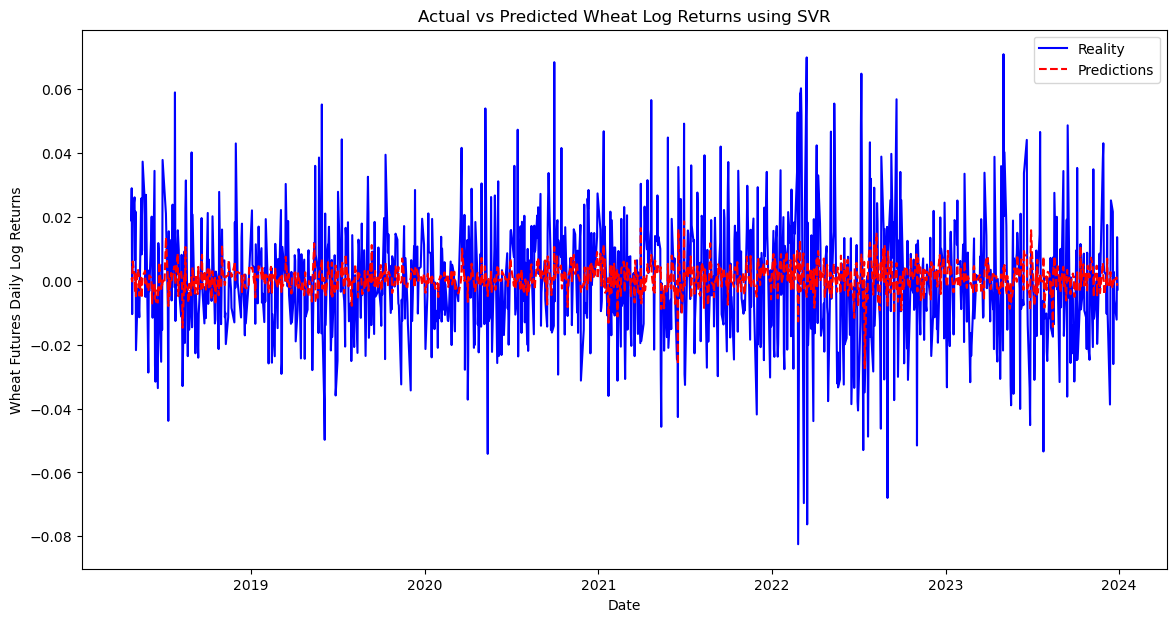

SVR - Mean Squared Error: 0.00034
SVR - Root Mean Squared Error: 0.01848
SVR - Mean Absolute Error: 0.01417
SVR - R2: 0.12393


In [35]:
# Define a function to find the best SVR model using Grid Search
def find_best_svr_model(train_labels, train_data):
    
    param_grid = {
        'C': [2],
        'epsilon': [0.01],
        'kernel': ['linear']
    }
    
    grid_search = GridSearchCV(SVR(), param_grid, cv=10, scoring='neg_mean_squared_error')
    grid_search.fit(train_data, train_labels)
    
    best_model = grid_search.best_estimator_
    return best_model

# Find the best SVR model
best_svr_model = find_best_svr_model(train_labels, train_data)
print("Best SVR model:", best_svr_model)

# Fit the SVR model with the best parameters
best_svr_model.fit(train_data, train_labels)

# Make predictions on the test data
predictions = best_svr_model.predict(test_data)

# Plot actual vs predicted log returns 
plt.figure(figsize=(14, 7))
plt.plot(dates_test, test_labels, label='Reality', color='blue')
plt.plot(dates_test, predictions, label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Wheat Futures Daily Log Returns')
plt.title('Actual vs Predicted Wheat Log Returns using SVR')
plt.legend()
plt.savefig('svr_predictionsvsreality_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate metrics
mse_svr = mean_squared_error(test_labels, predictions)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(test_labels, predictions)
r2_svr = r2_score(test_labels, predictions)

print(f'SVR - Mean Squared Error: {mse_svr:.5f}')
print(f'SVR - Root Mean Squared Error: {rmse_svr:.5f}')
print(f'SVR - Mean Absolute Error: {mae_svr:.5f}')
print(f'SVR - R2: {r2_svr:.5f}')

## Random Forest

Fitting 10 folds for each of 1 candidates, totalling 10 fits


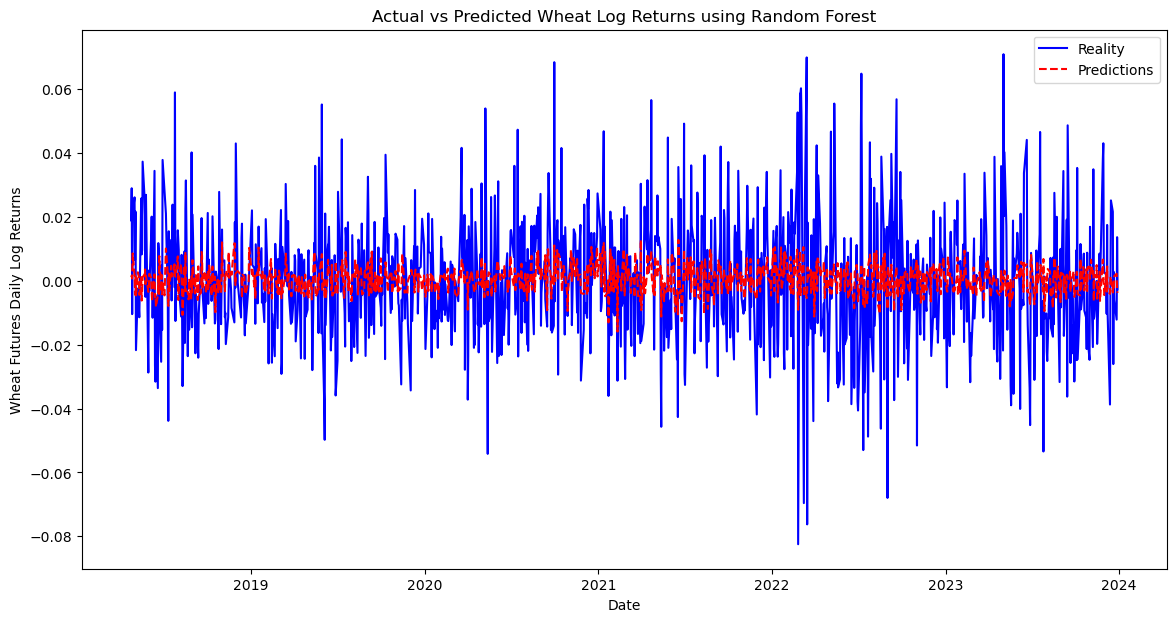

Best Random Forest - Mean Squared Error: 0.00035
Best Random Forest - Mean Absolute Error: 0.01421
Best Random Forest - Root Mean Squared Error: 0.01858
Best Random Forest - R2: 0.11443
Best parameters found:  {'bootstrap': True, 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 400}


In [36]:
# Define the parameter grid for Grid Search 
param_grid = {
    'n_estimators': [400],
    'max_depth':  [4],
    'min_samples_split': [40],
    'min_samples_leaf': [10],
    'bootstrap': [True]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=10,  # 10-fold cross-validation
                           n_jobs=-1,  
                           verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(train_data, train_labels)

# Extract the best estimator
best_rf = grid_search.best_estimator_

# Make predictions with the best estimator
best_rf_predictions = best_rf.predict(test_data)

# Plot actual vs predicted wheat log returns
plt.figure(figsize=(14, 7))
plt.plot(dates_test, test_labels, label='Reality', color='blue')
plt.plot(dates_test, best_rf_predictions, label='Predictions', color='red', linestyle='--')
plt.title('Actual vs Predicted Wheat Log Returns using Random Forest')
plt.xlabel('Date')
plt.ylabel('Wheat Futures Daily Log Returns')
plt.legend()
plt.savefig('rf_predictionsvsreality_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate metrics
mse_best_rf = mean_squared_error(test_labels, best_rf_predictions)
mae_best_rf = mean_absolute_error(test_labels, best_rf_predictions)
r2_best_rf = r2_score(test_labels, best_rf_predictions)
rmse_best_rf = np.sqrt(mse_best_rf)

print(f'Best Random Forest - Mean Squared Error: {mse_best_rf:.5f}')
print(f'Best Random Forest - Mean Absolute Error: {mae_best_rf:.5f}')
print(f'Best Random Forest - Root Mean Squared Error: {rmse_best_rf:.5f}')
print(f'Best Random Forest - R2: {r2_best_rf:.5f}')

# Output the best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

## Comparison with Benchmark Model

In [37]:
# Calculate the mean of the test labels
mean_prediction = np.mean(train_labels_seq)

# Create a mean prediction array
mean_predictions = np.full_like(test_labels_seq, mean_prediction)

# Calculate metrics for the mean benchmark model
benchmark_mse = mean_squared_error(test_labels_seq, mean_predictions)
benchmark_rmse = np.sqrt(benchmark_mse)
benchmark_mae = mean_absolute_error(test_labels_seq, mean_predictions)

# Compare MSE, RMSE, and MAE values
print(f'Benchmark Model MSE: {benchmark_mse:.6f}, RMSE: {benchmark_rmse:.6f}, MAE: {benchmark_mae:.6f}')
print(f'LSTM Model MSE: {lstm_mse:.6f}, RMSE: {lstm_rmse:.6f}, MAE: {lstm_mae:.6f}')
print(f'ARIMA Model MSE: {mse_arima:.6f}, RMSE: {rmse_arima:.6f}, MAE: {mae_arima:.6f}')
print(f'Random Forest Model MSE: {mse_best_rf:.6f}, RMSE: {rmse_best_rf:.6f}, MAE: {mae_best_rf:.6f}')
print(f'Support Vector Regression MSE: {mse_svr:.6f}, RMSE: {rmse_svr:.6f}, MAE: {mae_svr:.6f}')

Benchmark Model MSE: 0.000390, RMSE: 0.019740, MAE: 0.015170
LSTM Model MSE: 0.000389, RMSE: 0.019734, MAE: 0.015133
ARIMA Model MSE: 0.000342, RMSE: 0.018483, MAE: 0.014177
Random Forest Model MSE: 0.000345, RMSE: 0.018583, MAE: 0.014209
Support Vector Regression MSE: 0.000342, RMSE: 0.018483, MAE: 0.014171
